In [32]:
# 필수 package import
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
import torchvision.transforms as transforms
import torchvision.models as models


In [33]:
# GPU 사용 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [34]:
device

device(type='cuda')

In [35]:
def display_images_center_crop(image_paths, title, max_images=4):
    """이미지 중앙의 특정 영역을 크롭하여 시각화하는 함수."""
    plt.figure(figsize=(12, 3))
    for i, image_path in enumerate(image_paths[:max_images]):
        image = Image.open(image_path)
        width, height = image.size

        # 이미지 중앙의 정사각형 영역을 계산
        new_edge_length = min(width, height)
        left = (width - new_edge_length)/2
        top = (height - new_edge_length)/2
        right = (width + new_edge_length)/2
        bottom = (height + new_edge_length)/2

        # 중앙 영역 크롭
        image_cropped = image.crop((10, 20, width-10, height-15))

        # 크롭된 이미지 시각화
        plt.subplot(1, max_images, i+1)
        plt.imshow(image_cropped)
        plt.title(title)
        plt.axis('off')
    plt.show()

Train Glasses 이미지 개수: 52


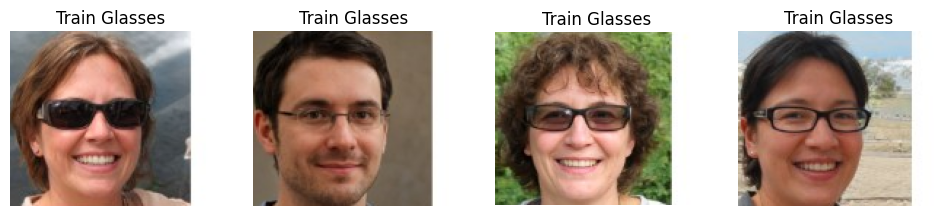

Train NoGlasses 이미지 개수: 52


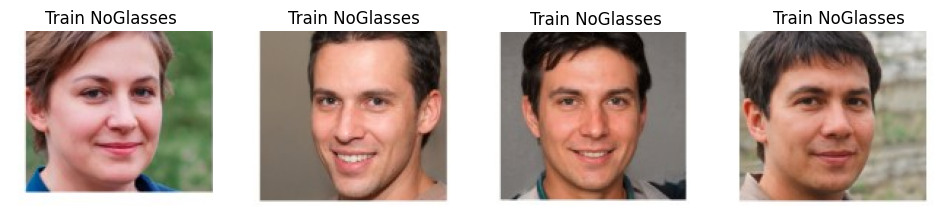

Val Glasses 이미지 개수: 20


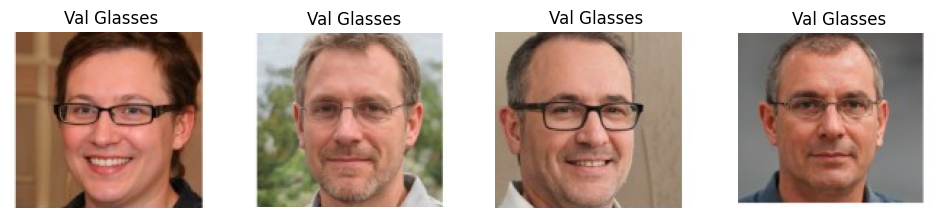

Val NoGlasses 이미지 개수: 20


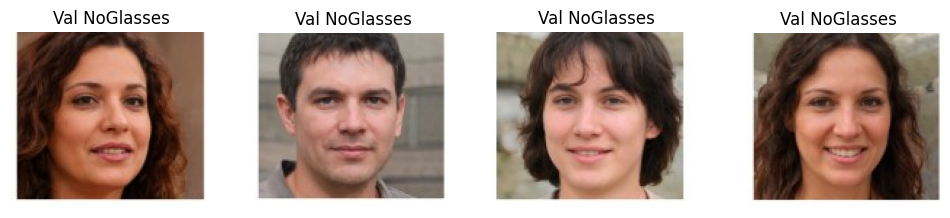

Test Glasses 이미지 개수: 10


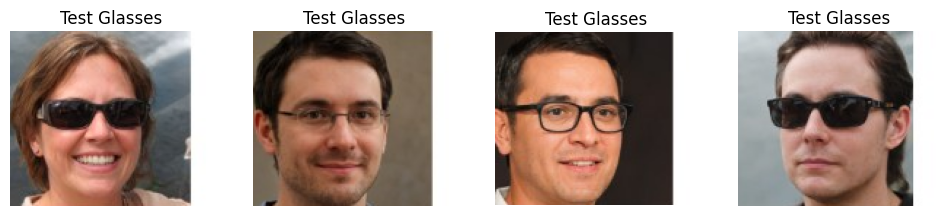

Test NoGlasses 이미지 개수: 10


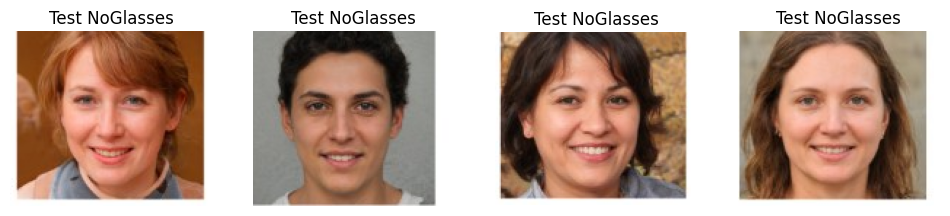

In [36]:
categories = ['Train Glasses', 'Train NoGlasses', 'Val Glasses', 'Val NoGlasses', 'Test Glasses', 'Test NoGlasses']

for category in categories:
    image_paths = glob.glob(f'../실습 파일/2/{category.lower().replace(" ", "/")}/*')
    print(f'{category} 이미지 개수: {len(image_paths)}')
    display_images_center_crop(image_paths, category)
    




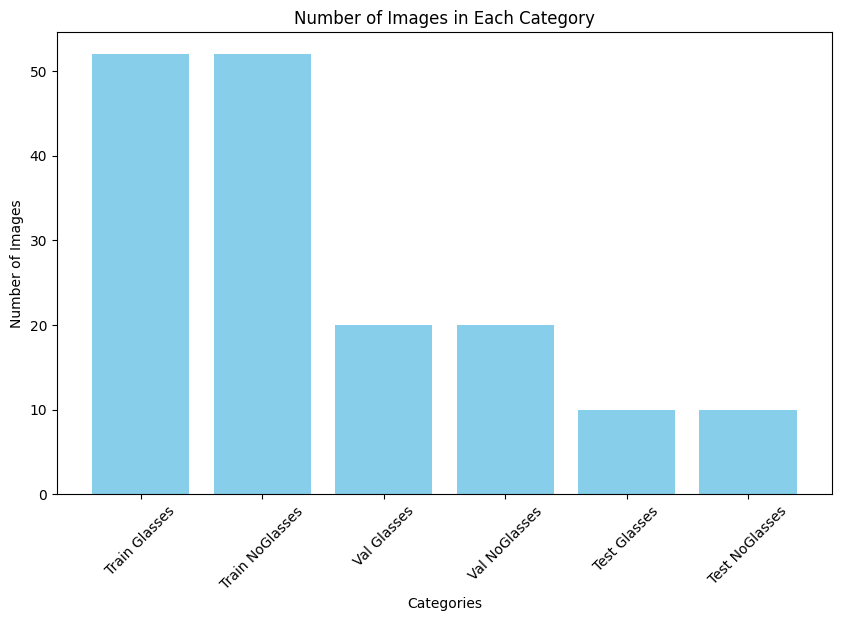

In [37]:
# 바 그래프 생성

plt.figure(figsize=(10, 6))
plt.bar(categories, [len(glob.glob(f'../실습 파일/2/{category.lower().replace(" ", "/")}/*')) for category in categories], color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Category')
plt.xticks(rotation=45)
plt.show()




In [38]:
# 데이터 전처리 정으
transform = transforms.Compose([
    transforms.CenterCrop(128),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])





In [39]:
# 데이터셋 로드 및 데이터 로더 생성
train_dataset = datasets.ImageFolder(root='../실습 파일/2/train', transform=transform)
val_dataset = datasets.ImageFolder(root='../실습 파일/2/val', transform=transform)
test_dataset = datasets.ImageFolder(root='../실습 파일/2/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [40]:
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        #Convolutional Layers
        self.conv1 = nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2)
        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        # MaxPooling Layers
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        # Fully Connected Layers
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)
        
    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxpool(self.conv5(x))
        # Flatten the output    
        x = x.view(x.size(0), 256 * 6 * 6)
        # Dropout
        x = F.dropout(F.relu(self.fc1(x)))
        x = F.dropout(F.relu(self.fc2(x)))

        x = self.fc3(x)
        return x





            


In [41]:
# 모델 초기화 및 GPU로 이동
net = AlexNet(num_classes=2)
net = net.to(device)

# 손실함수 및 최적화 함수 수정
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=0.0001, weight_decay=0.01)  # 학습률 감소 및 weight decay 추가


In [42]:
# calculate_accuracy 함수 수정
def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)  # GPU로 데이터 이동
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total



In [44]:
# 학습 및 검증 루프
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# 모델 학습
num_epochs = 20

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # GPU로 이동
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # 검증 손실 계산
    val_loss = 0.0
    net.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # GPU로 이동
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)
    
    # 훈련 및 검증 정확도 계산
    train_accuracy = calculate_accuracy(train_loader, net)
    train_accuracies.append(train_accuracy)
    
    val_accuracy = calculate_accuracy(val_loader, net)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%')
            
        
        





Epoch 1/20, Train Loss: 0.6942, Val Loss: 0.6846, Train Accuracy: 65.38%, Val Accuracy: 60.00%
Epoch 2/20, Train Loss: 0.6907, Val Loss: 0.7187, Train Accuracy: 50.00%, Val Accuracy: 52.50%
Epoch 3/20, Train Loss: 0.6934, Val Loss: 0.7007, Train Accuracy: 52.88%, Val Accuracy: 50.00%
Epoch 4/20, Train Loss: 0.6625, Val Loss: 0.6211, Train Accuracy: 71.15%, Val Accuracy: 52.50%
Epoch 5/20, Train Loss: 0.5797, Val Loss: 0.5321, Train Accuracy: 85.58%, Val Accuracy: 67.50%
Epoch 6/20, Train Loss: 0.4406, Val Loss: 0.5073, Train Accuracy: 85.58%, Val Accuracy: 70.00%
Epoch 7/20, Train Loss: 0.4088, Val Loss: 1.5773, Train Accuracy: 63.46%, Val Accuracy: 52.50%
Epoch 8/20, Train Loss: 0.6638, Val Loss: 0.5328, Train Accuracy: 85.58%, Val Accuracy: 72.50%
Epoch 9/20, Train Loss: 0.4509, Val Loss: 0.4911, Train Accuracy: 84.62%, Val Accuracy: 72.50%
Epoch 10/20, Train Loss: 0.3549, Val Loss: 0.6434, Train Accuracy: 83.65%, Val Accuracy: 62.50%
Epoch 11/20, Train Loss: 0.2796, Val Loss: 0.6269

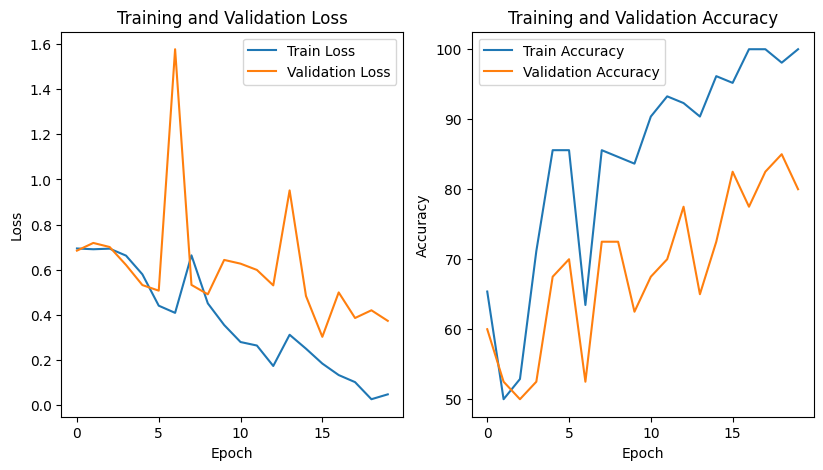

In [46]:
# 학습 손실과 검증 정확도 그래프 그리기

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


In [48]:
def load_and_transform_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    width, height = image.size
    
    left = (width - 128)/2
    top = (height - 128)/2
    right = (width + 128)/2
    bottom = (height + 128)/2
    image_cropped = image.crop((left, top, right, bottom))
    
    return transform(image_cropped), image_cropped





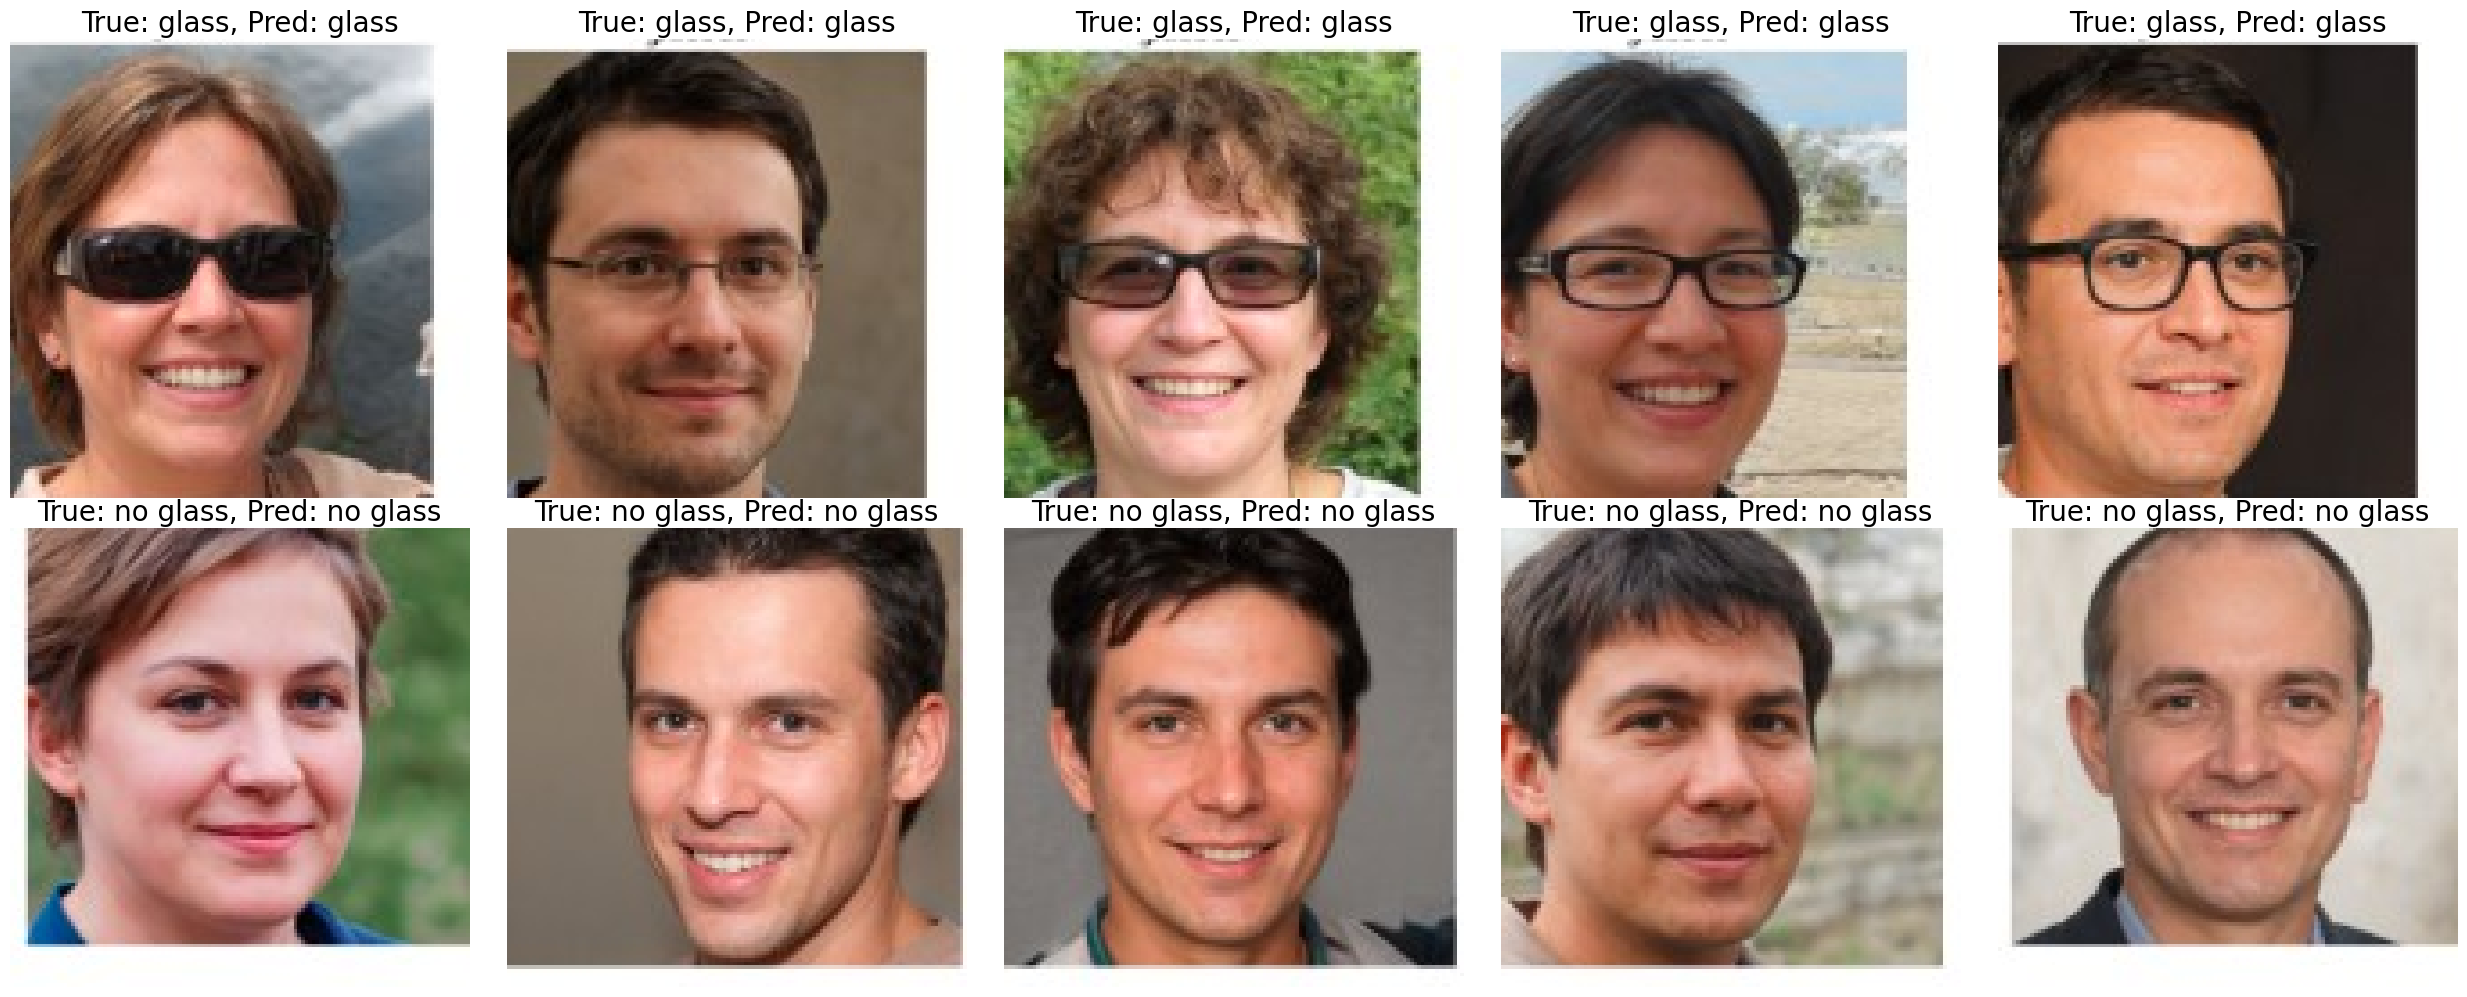

In [58]:
import random

# 클래스별 폴더 경로
class_folders = {
    'glass' : '../실습 파일/2/train/glasses',
    'no glass' : '../실습 파일/2/train/noglasses'
}

plt.figure(figsize=(25, 10))

counter = 1

for class_name, folder_path in class_folders.items():
    # 해당 클래스의 이미지 경로 가져오기
    image_paths = glob.glob(os.path.join(folder_path, '*'))
    selected_paths = image_paths[:5]  # 첫 5장 선택

    for image_path in selected_paths:
        image, image_cropped = load_and_transform_image(image_path, transform)
        image_unsqueeze = image.unsqueeze(0)  # 배치 차원 추가
        image_unsqueeze = image_unsqueeze.to(device)
        # 모델을 사용한 추론
        output = net(image_unsqueeze)
        _, predicted = torch.max(output, 1)
        prediction = 'glass' if predicted.item() == 0 else 'no glass'

        # 결과 시각화
        plt.subplot(2, 5, counter)
        plt.imshow(image_cropped)
        plt.title(f'True: {class_name}, Pred: {prediction}', fontsize=20)
        plt.axis('off')

        counter += 1  # subplot 인덱스 업데이트

plt.tight_layout()
plt.show()